The following is an example of how we parsed the Labelbox annotations to create our training and validation sets.

In [2]:
import pandas as pd
import numpy as np
from skimage.draw import rectangle_perimeter
import skimage
import skimage.io as io
from skimage.transform import resize
import pickle

from matplotlib.pyplot import figure

from utils import * 

Prepare the file paths and filter the data.

In [1]:
ANNOTATION_PATH = {} # add path 
DATA_PATH = {} # add path

class_dictionary = {"Yeast White": 0, "Budding White": 1, "Yeast Opaque": 2,
                           "Budding Opaque":3,"Yeast Gray": 4, "Budding Gray": 5,
                            "Shmoo":6,"Pseudohyphae": 7, "Hyphae": 8, "H-junction": 9,
                           "P-junction":10,"Artifact": 11, "Unknown ": 12,"P-Start":13,"H-Start":14}

In [3]:
labels = pd.read_json(ANNOTATION_PATH)
labels = pd.concat((labels[labels["Dataset Name"] == "Set 2"],labels[labels["Dataset Name"] == "Set 3"],
                   labels[labels["Dataset Name"] == "Unlabelled Pure"],
                   labels[labels["Dataset Name"] == "Impure Pseudohyphae"]))

ls = pd.read_excel("learning_set.xlsx") # Path to the learning set
accepted_images = ls[ls["Learning set"] == "Yes"]["original_file_name"].values

Use the raw annotation file from Labelbox and parse them into the correct format required by mmdetection.  The final result will be an array called `train_images` which contains a single entry in the COCO format.

In [245]:
train_images = []

for index, row in labels.iterrows():
    # Check that it wasn't skipped 
    if bool(row["Label"]): 
        #Check that it wasn't mislabeled.
        mislabels = len(set(j["title"] for j in row["Label"]["objects"]).difference(set(class_dictionary.keys())))
        if mislabels == 0:
            #Prepare to extract the image, bounding box coordinates and the class id
            image = io.imread(DATA_PATH + row["External ID"]) 
            bbox = []
            class_id = []
            for j in row["Label"]["objects"]:
                # Labelbox gives coordinates in (y,x,heigh,width)
                bbox.append([j["bbox"]['top'],j["bbox"]["left"],j["bbox"]["height"],j["bbox"]["width"]])    
                class_id.append(class_dictionary[j["title"]])

            # Crop half of the image and resize. For now we just select the DIC side.
            bbox, image = crop_and_resize(image,np.array(bbox))
             #This changes the bounding box coordinates from (y1,x1,height,width) to (x1,y1,x2,y2) which mmdetection requires
            bbox = np.array([np.array([i[1],i[0],i[3],i[2]]) for i in bbox]) 
            bbox = centre_to_rect(bbox)
            if row["External ID"] in accepted_images:
                train_data.append({"image": image,"bbox": bbox,"labels": class_id,'filename':row["External ID"]})
        

Take a look at one of the examples as a sanity check.

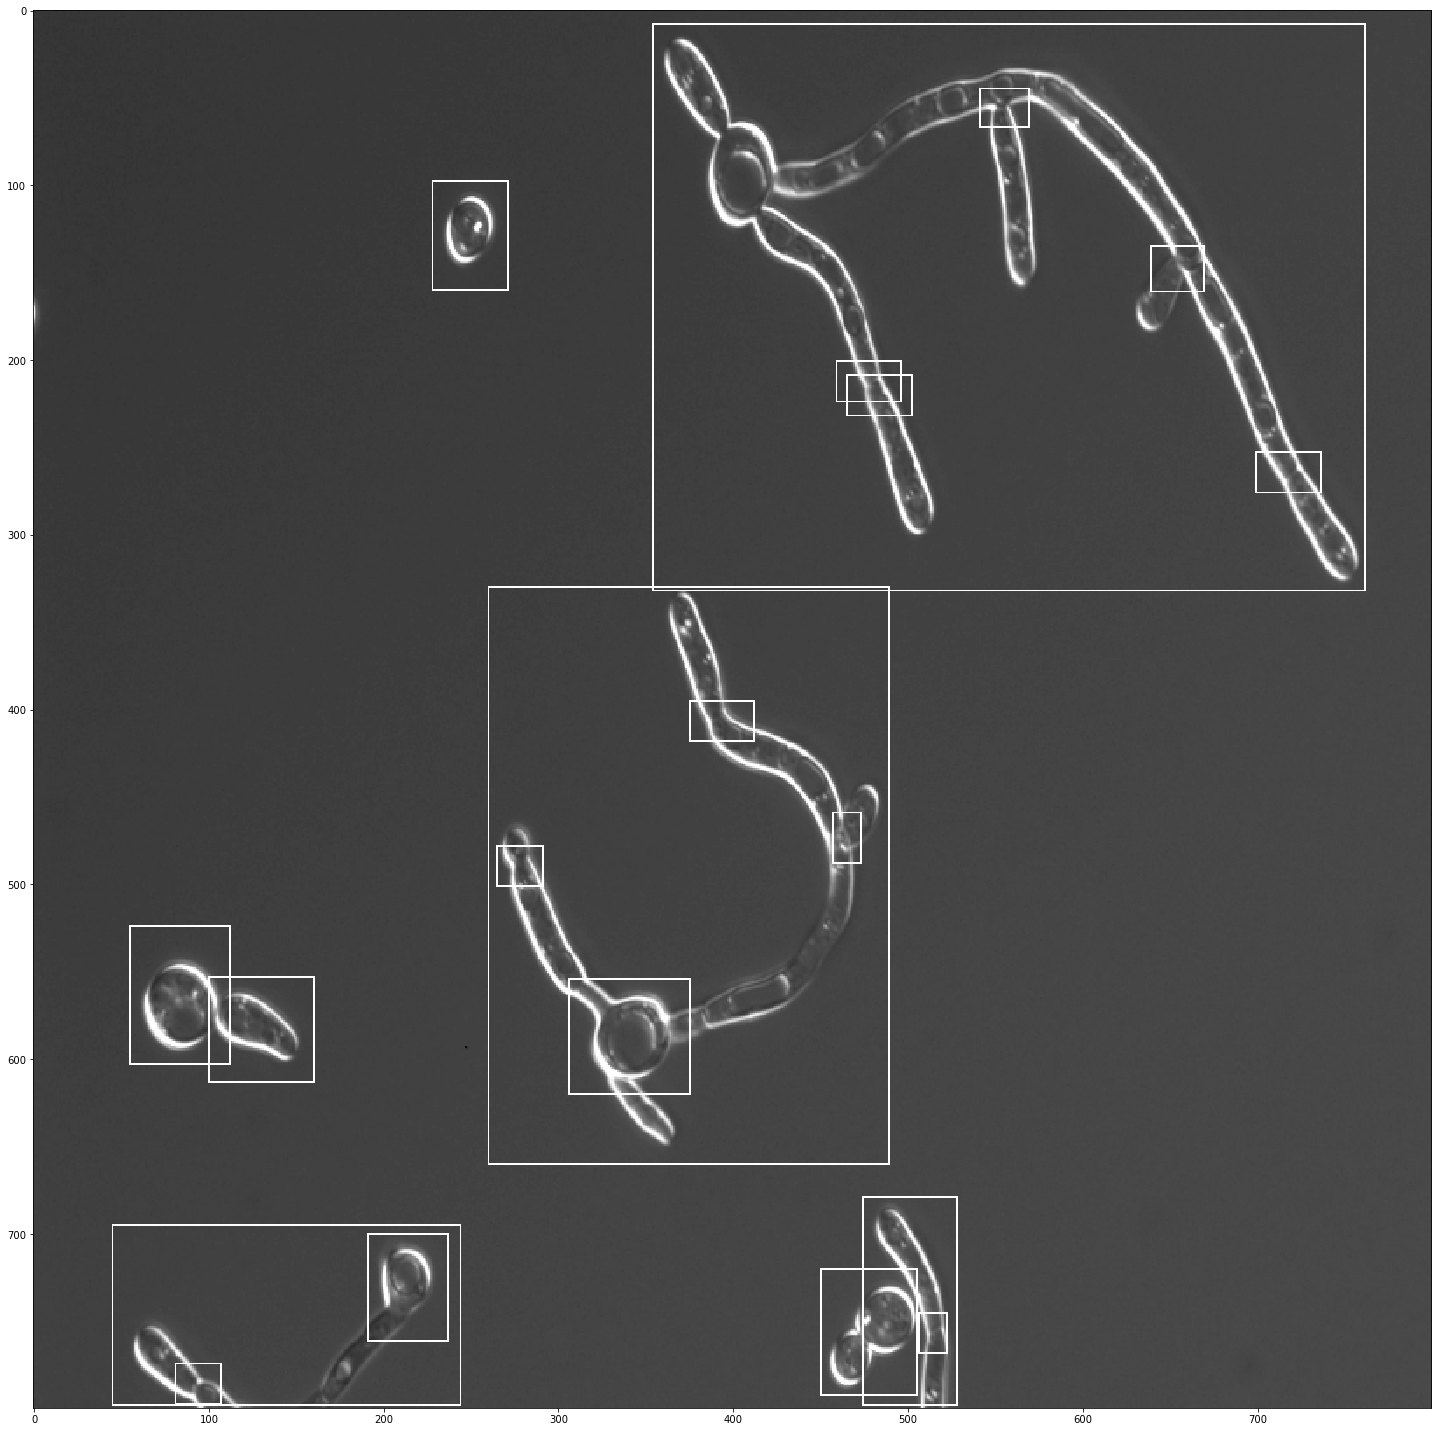

In [235]:
draw_bounding_boxes(train_images[350]["image"],train_images[350]["bbox"])

Finally, split the data into a train/val split and save it the file format expected by mmdetection. NOTE: This will have to match whatever you specify in your `config.py` file.

In [247]:
  """Save the train/val data in the COCO data format"""
    train_index = []
    val_index = []
    numbers = list(range(len(train_images)))
    split = int(len(train_images)*split)
    print(split)
    for k in range(split):
        i = numbers.pop(np.random.randint(len(numbers)))
        train_index.append(i)
    for k in range(split,len(train_images)):
        i = numbers.pop(np.random.randint(len(numbers)))
        val_index.append(i)
        
    # Save training data 
    train_data_path = path + "/train"
    train_annotations = []
    for i in train_index:
        new_entry = {}
        new_entry['filename'] = path + "/train/" + train_images[i]["filename"] 
        #new_entry['filename'] = path + "/_" + str(i) + ".png" 
        new_entry["width"] = 800
        new_entry["height"] = 800
        new_entry["ann"] = {}
        new_entry["ann"]["bboxes"] = np.array(np.array(train_images[i]["bbox"]),dtype = np.float32)
        #new_entry["ann"]["bboxes"] = np.array(train_images[i]["bbox"],dtype = np.float32)
        new_entry["ann"]["labels"] = np.array(train_images[i]["labels"],dtype = np.int64)
        train_annotations.append(new_entry)
    with open(path + "/annotations/train/" + "train_annotations.pkl" ,'wb') as f:
        pickle.dump(train_annotations, f)
        
    for i in train_index:
        image = train_images[i]["image"]
        io.imsave(path + "/train/" + train_images[i]['filename'],image)
        
        
    #Save validation data
    val_data_path = path + "/val"
    val_annotations = []
    for i in val_index:
        new_entry = {}
        new_entry['filename'] = path + "/val/" + train_images[i]["filename"] 
        #new_entry['filename'] = path + "/_" + str(i) + ".png" 
        new_entry["width"] = 800
        new_entry["height"] = 800
        new_entry["ann"] = {}
        new_entry["ann"]["bboxes"] = np.array(np.array(train_images[i]["bbox"]),dtype = np.float32)
        #new_entry["ann"]["bboxes"] = np.array(train_images[i]["bbox"],dtype = np.float32)
        new_entry["ann"]["labels"] = np.array(train_images[i]["labels"],dtype = np.int64)
        val_annotations.append(new_entry)
    with open(path + "/annotations/val/" + "val_annotations.pkl" ,'wb') as f:
        pickle.dump(val_annotations, f)
        
    for i in val_index:
        image = train_images[i]["image"]
        io.imsave(path + "/val/" + train_images[i]['filename'],image)